In [232]:
# imports and project root
from pathlib import Path
import rasterio
import rasterio.plot
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
# choose latest ACI v# and inspect metadata
import re

In [233]:

# set project root and year
project_root = Path.cwd().parents[0]
year = 2017  # change as needed

# input dir
aci_dir = project_root / "data" / "raw" / str(year)

# load crop class reference
ref_path = project_root / "data" / "reference" / "aci_crop_classifications_iac_classifications_des_cultures.csv"
classes_df = pd.read_csv(ref_path)

# load RM boundaries
muni_path = project_root / "data" / "reference" / "municipalities.geojson"
muni_gdf = gpd.read_file(muni_path)

# load imputed MASC data for the same year
masc_path = project_root / "data" / "interim" / str(year) / f"masc_imputed_{year}.csv"
masc_df = pd.read_csv(masc_path)


In [234]:
def choose_aci_for_year(aci_dir: Path, year: int) -> Path:
    candidates = sorted(aci_dir.glob(f"aci_{year}_mb_v*.tif"))
    if not candidates:
        raise FileNotFoundError(f"No ACI raster found in {aci_dir} matching aci_{year}_mb_v*.tif")
    def v_key(p: Path):
        m = re.search(r"_v(\d+)\.tif$", p.name)
        return int(m.group(1)) if m else -1
    return max(candidates, key=v_key)

aci_path = choose_aci_for_year(aci_dir, year)
print(f"Using raster: {aci_path.name}")

Using raster: aci_2017_mb_v3.tif


In [235]:
with rasterio.open(aci_path) as src:
    print("CRS:", src.crs)
    print("Width:", src.width)
    print("Height:", src.height)
    print("Bounds:", src.bounds)
    print("Transform:", src.transform)

CRS: PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",44.75],PARAMETER["standard_parallel_2",55.75],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width: 15093
Height: 19341
Bounds: BoundingBox(left=-391080.0, bottom=998970.0, right=61710.0, top=1579200.0)
Transform: | 30.00, 0.00,-391080.00|
| 0.00,-30.00, 1579200.00|
| 0.00, 0.00, 1.00|


Raster is in Albers Conic Equal Area, the same projection AAFC uses for all Manitoba ACI tiles.

From the metadata:
- Pixel size: 30 m
- Extent: roughly 1,008 km wide × 2,163 km tall (≈ Manitoba + buffer)
- CRS: custom Albers, close to EPSG:102001 (but not officially tagged)
- Transform: origin top-left, standard orientation.

In [236]:
# show structure
print(classes_df.columns.tolist())
print(classes_df.head())

['Code', 'Red', 'Green', 'Blue', 'Label', 'Étiquette']
   Code  Red  Green  Blue                Label                 Étiquette
0    10    0      0     0                Cloud                    Nuages
1    20   51     51   255                Water                       Eau
2    30  153    102   102  Exposed land/barren  Sols nus/terres stériles
3    34  204    102   153      Urban/developed        Milieu urbain/bâti
4    35  225    225   225          Greenhouses                    Serres


In [237]:
with rasterio.open(aci_path) as src:
    data = src.read(1)

# flatten and count
unique, counts = np.unique(data, return_counts=True)
counts_df = pd.DataFrame({"Code": unique, "pixel_count": counts})

# merge with reference
merged = counts_df.merge(classes_df[["Code", "Label", "Étiquette"]], on="Code", how="left")

In [238]:
# sort by pixel count
merged = merged.sort_values("pixel_count", ascending=False).reset_index(drop=True)

# pixel area conversions
pixel_area_m2 = 30 * 30  # 900 m² per pixel
merged["hectares"] = merged["pixel_count"] * pixel_area_m2 / 10_000
merged["acres"] = merged["pixel_count"] * pixel_area_m2 / 4046.8564224

pd.options.display.float_format = '{:,.3f}'.format

merged.head(50)

,Code,pixel_count,Label,Étiquette,hectares,acres
0,0,92059244,NaN,NaN,"8,285,331.960","20,473,501.146"
1,20,30542852,Water,Eau,"2,748,856.680","6,792,572.785"
2,80,28331900,Wetland,Terres humides,"2,549,871.000","6,300,868.461"
3,220,27267455,Broadleaf,Forêt de feuillus,"2,454,070.950","6,064,141.382"
4,110,18104138,Grassland,Prairies,"1,629,372.420","4,026,266.934"
5,210,16321286,Coniferous,Forêt de conifères,"1,468,915.740","3,629,769.843"
6,153,15213600,Canola/rapeseed,Canola/colza,"1,369,224.000","3,383,426.188"
7,146,12339773,Spring wheat,Blé de printemps,"1,110,579.570","2,744,301.883"
8,158,11748528,Soybeans,Soya,"1,057,367.520","2,612,812.044"
9,50,9863889,Shrubland,Arbustaie,"887,750.010","2,193,678.049"


- Code 0 (≈ 151 M pixels, 13.6 M ha) has no label. That’s the nodata / unclassified area.
- 13.6 M ha represents the area north of the classified area. The raster doesn't map out the entire province, so the northern area is Code 0
- All other codes are successfully matched to English and French labels — good sign that the reference CSV aligns with this ACI version.
- The magnitudes are reasonable: total mapped land ≈ 13.6 M ha + all other classes ≈ 26 M ha total, consistent with Manitoba’s provincial area (~65 M acres = 26 M ha).

In [239]:
# show crs and bounds
print("Municipality CRS:", muni_gdf.crs)
print("Raster CRS:", src.crs)

print("Municipality bounds:", muni_gdf.total_bounds)
print("Raster bounds:", src.bounds)

Municipality CRS: EPSG:4326
Raster CRS: PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",44.75],PARAMETER["standard_parallel_2",55.75],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Municipality bounds: [-101.88467634   48.99893654  -93.68318542   58.79357615]
Raster bounds: BoundingBox(left=-391080.0, bottom=998970.0, right=61710.0, top=1579200.0)


This confirms the raster and municipal geometries are in different coordinate systems.
- Municipalities: geographic (EPSG:4326, degrees).
- Raster: Albers Conic Equal Area, projected in metres.

Before allocating pixels to RMs, we’ll need to reproject the municipal layer to match the raster’s CRS.
Since the raster’s CRS is custom and unnamed, safest approach is to reproject using its exact src.crs definition rather than an EPSG code.

In [240]:
with rasterio.open(aci_path) as src:
    albers_crs = src.crs

muni_albers = muni_gdf.to_crs(albers_crs)
print("Reprojected CRS:", muni_albers.crs)
print("New bounds:", muni_albers.total_bounds)

Reprojected CRS: PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",44.75],PARAMETER["standard_parallel_2",55.75],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
New bounds: [-391122.17317956  998966.09683802  142852.66073413 2091649.15789945]


The reprojected bounds now align numerically with the raster’s extent (metres, not degrees), confirming spatial compatibility.

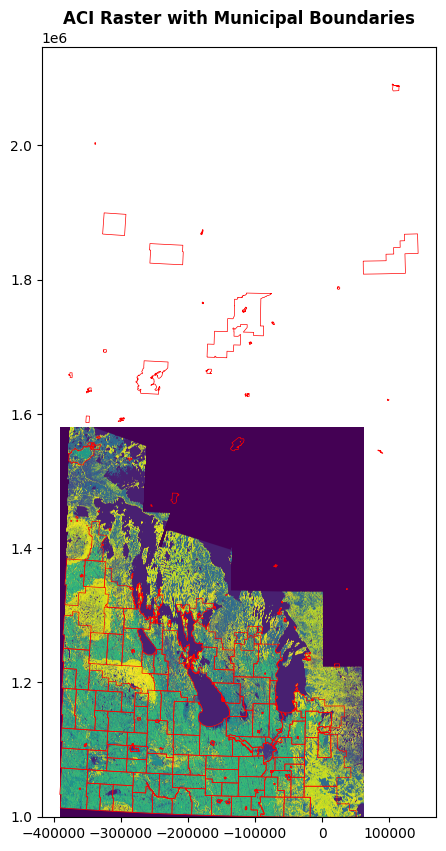

In [241]:
with rasterio.open(aci_path) as src:
    fig, ax = plt.subplots(figsize=(8, 10))
    rasterio.plot.show(src, ax=ax, title="ACI Raster with Municipal Boundaries")
    muni_albers.boundary.plot(ax=ax, linewidth=0.5, color="red")
    plt.show()

This is fully consistent with the AAFC Annual Crop Inventory’s intended coverage — it only maps
the agriculturally active portion of Canada, not the full provincial extent.

This means the raster stops roughly around the boreal transition near Flin Flon/The Pas, leaving the northern
municipalities (e.g., Churchill, Gillam, etc.) outside its classification area.

This has two practical implications for the biomass mapping workflow:
- Zonal summaries: When aggregating by RM, northern municipalities will have zero or near-zero valid pixels.
That’s expected — they can remain with nulls or zeros in output tables.
- Visualization: Any map derived from ACI data should clip or mask to the raster’s
actual coverage to avoid misleading blank zones.

The alignment is verified and geographically correct.

In [242]:
muni_albers.columns
muni_albers.head(3)

,OBJECTID,MUNI_NO,MUNI_NAME,MUNI_TYPE,MUNI_LIST_NAME,MUNI_LIST_NAME_WITH_TYPE,Shape__Area,Shape__Length,geometry
0,1,189,RM OF SPRINGFIELD,RM,SPRINGFIELD,SPRINGFIELD (RM),"2,601,484,408.703","269,137.502","POLYGON ((-45327.719 1117499.704, -45327.438 1..."
1,2,102,RM OF ARGYLE,RM,ARGYLE,ARGYLE (RM),"1,909,428,965.676","206,734.857","POLYGON ((-242073.602 1063943.162, -242111.603..."
2,3,169,RM OF ROLAND,RM,ROLAND,ROLAND (RM),"1,142,974,690.891","136,057.89","POLYGON ((-124952.789 1049978.305, -125755.553..."


In [243]:
# compute pixel counts per RM polygon
stats = zonal_stats(
    muni_albers,
    aci_path,
    categorical=True,
    nodata=0,
    all_touched=False,
)

In [244]:
# convert to DataFrame
rows = []
for i, stat in enumerate(stats):
    muni = muni_albers.loc[i, "MUNI_NAME"]
    for code, count in stat.items():
        rows.append({"MUNI_NAME": muni, "Code": int(code), "pixel_count": count})

zonal_df = pd.DataFrame(rows)

In [245]:
# merge with crop reference
merged_zonal = zonal_df.merge(classes_df[["Code", "Label", "Étiquette"]], on="Code", how="left")

# add area conversions
pixel_area_m2 = 30 * 30
merged_zonal["hectares"] = merged_zonal["pixel_count"] * pixel_area_m2 / 10_000
merged_zonal["acres"] = merged_zonal["pixel_count"] * pixel_area_m2 / 4_046.8564224

In [246]:
merged_zonal.head(20)

,MUNI_NAME,Code,pixel_count,Label,Étiquette,hectares,acres
0,RM OF SPRINGFIELD,20,3175,Water,Eau,285.750,706.104
1,RM OF SPRINGFIELD,30,40998,Exposed land/barren,Sols nus/terres stériles,"3,689.820","9,117.744"
2,RM OF SPRINGFIELD,34,85166,Urban/developed,Milieu urbain/bâti,"7,664.940","18,940.479"
3,RM OF SPRINGFIELD,35,4,Greenhouses,Serres,0.360,0.890
4,RM OF SPRINGFIELD,50,24103,Shrubland,Arbustaie,"2,169.270","5,360.383"
5,RM OF SPRINGFIELD,80,38795,Wetland,Terres humides,"3,491.550","8,627.808"
6,RM OF SPRINGFIELD,110,218394,Grassland,Prairies,"19,655.460","48,569.699"
7,RM OF SPRINGFIELD,122,55271,Pasture/forages,Pâturage/cultures fourragères,"4,974.390","12,291.985"
8,RM OF SPRINGFIELD,130,158,Too wet to be seeded,Trop humide pour l’ensemencement,14.220,35.138
9,RM OF SPRINGFIELD,133,8219,Barley,Orge,739.710,"1,827.863"


In [247]:
# define agricultural and related labels per your list
label_set = [
    "Agriculture (undifferentiated)",
    "Pasture/forages",
    "Too wet to be seeded",
    "Fallow",
    "Cereals",
    "Barley",
    "Other grains",
    "Millet",
    "Oats",
    "Rye",
    "Spelt",
    "Triticale",
    "Wheat",
    "Winter wheat",
    "Spring wheat",
    "Oilseeds",
    "Borage",
    "Camelina",
    "Canola/rapeseed",
    "Flaxseed",
    "Mustard",
    "Safflower",
    "Sunflower",
    "Soybeans",
    "Pulses",
    "Peas",
    "Chickpeas",
    "Beans",
    "Fababeans",
    "Lentils",
    "Vegetables",
    "Tomatoes",
    "Potatoes",
    "Sugarbeets",
    "Other vegetables",
    "Fruits",
    "Sorghum",
    "Quinoa",
    "Corn",
    "Tobacco",
    "Ginseng",
    "Other pulses",
    "Berries",
    "Blueberry",
    "Cranberry",
    "Other berries",
    "Orchards",
    "Other fruits",
    "Vineyards",
    "Hops",
    "Sod",
    "Herbs",
    "Buckwheat",
    "Canaryseed",
    "Hemp",
    "Switchgrass",
    "Vetch",
    "Other crops"
]

# tidy reference labels
classes_df["Label"] = classes_df["Label"].astype(str).str.strip()

# find which requested labels are missing from the reference table (sanity check)
missing_labels = sorted(set(label_set) - set(classes_df["Label"].unique()))
print("Labels not found in reference:", missing_labels)

# map labels to codes from the reference table
label_to_code = classes_df.set_index("Label")["Code"]
ag_codes_full = [int(label_to_code[l]) for l in label_set if l in label_to_code.index]

# keep only codes that actually appear in the raster zonal results
present_codes = set(merged_zonal["Code"].unique())
ag_codes = [c for c in ag_codes_full if c in present_codes]

# filter and summarize
ag_zonal = merged_zonal[merged_zonal["Code"].isin(ag_codes)].copy()

ag_summary = (
    ag_zonal.groupby(["Label"], as_index=False)
    .agg(pixel_count=("pixel_count","sum"),
         hectares=("hectares","sum"),
         acres=("acres","sum"))
    .sort_values("hectares", ascending=False)
    .reset_index(drop=True)
)

ag_summary.head(50)


Labels not found in reference: []


,Label,pixel_count,hectares,acres
0,Canola/rapeseed,15209253,"1,368,832.770","3,382,459.438"
1,Spring wheat,12329938,"1,109,694.420","2,742,114.630"
2,Soybeans,11742586,"1,056,832.740","2,611,490.574"
3,Pasture/forages,7020243,"631,821.870","1,561,265.842"
4,Corn,2301595,"207,143.550","511,862.859"
5,Oats,1574998,"141,749.820","350,271.433"
6,Barley,788095,"70,928.550","175,268.264"
7,Beans,551145,"49,603.050","122,571.806"
8,Too wet to be seeded,314316,"28,288.440","69,902.258"
9,Rye,267769,"24,099.210","59,550.445"


In [248]:
print(f"Loaded {len(masc_df)} rows from {masc_path.name}")
masc_df.head(10)

Loaded 11987 rows from masc_imputed_2017.csv


,year,rm,crop,variety,farms,acres,yield_per_acre,yield,imputed
0,2017,DAUPHIN,HEMP GRAIN,CANDA,3,862.000,0.337,290.494,0
1,2017,ROCKWOOD,WHITE PEA BEANS,ENVOY,3,542.000,0.319,172.898,0
2,2017,DAUPHIN,HEMP GRAIN,CRS-1,3,"1,567.000",0.273,427.791,0
3,2017,BIFROST-RIVERTON,PED. TIMOTHY SEED,ATURO (NORTH STAR),3,648.000,0.226,146.448,0
4,2017,GILBERT PLAINS,HEMP GRAIN,CANDA,3,"1,177.000",0.199,234.223,0
5,2017,NORTH CYPRESS-LANGFORD,PROC POTATOES-IRRIG,UMATILLA RUSSET,3,943.000,19.095,"18,006.585",0
6,2017,STANLEY,TABLE POTATOES,MUSICA,5,644.000,17.709,"11,404.596",0
7,2017,FISHER,PED. TIMOTHY SEED,CLIMAX,6,780.000,0.172,134.160,0
8,2017,PORTAGE LA PRAIRIE,PROC POTATOES-IRRIG,INNOVATOR,4,"1,213.000",16.917,"20,520.321",0
9,2017,NORTH NORFOLK,PROC POTATOES-IRRIG,RUSSET BURBANK (GEMS),7,"1,879.000",16.904,"31,762.616",0


In [249]:
# collapse to province-wide totals by crop
masc_crop_totals = (
    masc_df.groupby("crop", as_index=False)
    .agg(
        acres=("acres", "sum"),
        yield_tonnes=("yield", "sum"),
        avg_yield_per_acre=("yield_per_acre", "mean"),
        farms=("farms", "sum")
    )
    .sort_values("acres", ascending=False)
    .reset_index(drop=True)
)

masc_crop_totals.head(50)

,crop,acres,yield_tonnes,avg_yield_per_acre,farms
0,ARGENTINE CANOLA,"3,029,521.138","3,190,981.211",0.961,10320
1,SOYBEANS,"2,146,761.627","1,960,162.658",0.847,8508
2,RED SPRING WHEAT,"2,024,780.061","3,686,058.602",1.655,5875
3,OATS,"440,258.583","877,778.236",1.803,2140
4,GRAIN CORN,"381,853.609","1,270,970.442",3.068,2049
5,ALFALFA/GRASS MIX.,"291,770.653","369,557.010",1.181,2931
6,BARLEY,"230,751.415","428,208.660",1.723,997
7,NORTH. HARD RED WHT,"206,760.413","450,422.756",2.021,525
8,ALFALFA,"132,223.927","226,343.410",1.557,1278
9,SILAGE CORN,"100,661.843","1,122,420.446",10.977,710


In [250]:
ag_summary.head(50)

,Label,pixel_count,hectares,acres
0,Canola/rapeseed,15209253,"1,368,832.770","3,382,459.438"
1,Spring wheat,12329938,"1,109,694.420","2,742,114.630"
2,Soybeans,11742586,"1,056,832.740","2,611,490.574"
3,Pasture/forages,7020243,"631,821.870","1,561,265.842"
4,Corn,2301595,"207,143.550","511,862.859"
5,Oats,1574998,"141,749.820","350,271.433"
6,Barley,788095,"70,928.550","175,268.264"
7,Beans,551145,"49,603.050","122,571.806"
8,Too wet to be seeded,314316,"28,288.440","69,902.258"
9,Rye,267769,"24,099.210","59,550.445"


In [251]:
aci_total_acres = ag_summary["acres"].sum()
masc_total_acres = masc_crop_totals["acres"].sum()
aci_total_acres, masc_total_acres

(np.float64(11846000.993425308), np.float64(9887981.800000003))

I've decided to compare aci and masc data in a new notebook.

In [252]:
# export ACI agricultural summary for use in comparison notebook
out_path = project_root / "data" / "interim" / str(year) / f"aci_ag_summary_{year}.csv"
ag_summary.to_csv(out_path, index=False)
print(f"Saved: {out_path}")

Saved: /Users/dpro/projects/biomass/subprojects/mapping/ag_res/data/interim/2017/aci_ag_summary_2017.csv
